In [1]:
# Dance to import our logit model
import os
import sys
module_path = os.path.abspath(os.path.join('.'))
sys.path.append(module_path)
from k_means import KMeans
from voronoi_processing import get_polygons, interpolate_centroid_history

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from celluloid import Camera
from scipy.spatial.distance import cdist
from sklearn.datasets import make_blobs

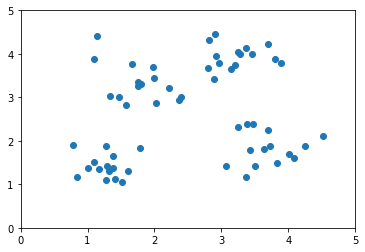

In [4]:
# data, _ = make_blobs(60, cluster_std=[0.3, 0.4, 0.4, 0.3], center_box=[0.5, 4.5], 
#                      centers=[[1.3, 1.2], [1.8, 3.4], [3.4, 4], [3.8, 1.8]])
data = np.load("data/synth_data.npy")

plt.xlim(0, 5)
plt.ylim(0, 5)
plt.scatter(data[:, 0], data[:, 1])

In [6]:
centroid_original = KMeans(4, centroid_init="kmeans++", verbose=True)
centroid_original.fit(data)
centroid_history = interpolate_centroid_history(centroid_original.centroid_history, 70, 2)

Iteration: 0
Iteration: 1
Iteration: 2


In [5]:

centroid_history = np.load("data/centroid_history1.npy")


In [ ]:
cmap = plt.get_cmap("jet")
colors = [
    cmap(0.25),
    cmap(0.45),
    cmap(0.75),
    cmap(0.9),
]

fig = plt.figure()
plt.xlim(0, 5)
plt.ylim(0, 5)
camera = Camera(fig)
for i in range(len(centroid_history)):
# for i in range(1):
    polygons = get_polygons(centroid_history[i], [0, 5], [0, 5])
    labels = centroid_original._get_labels(data, centroid_history[i])
    for j, p in enumerate(polygons):
        
        color = colors[j]
        
        plt.scatter(data[labels==j, 0], data[labels==j, 1], color=color, s=15)
        plt.fill(p[:, 0], p[:, 1], c=color, alpha=0.5, edgecolor="black")
        plt.scatter(centroid_history[i][j, 0], centroid_history[i][j, 1], s=60, color=color, edgecolor="black")
        
    camera.snap()

animation = camera.animate()
animation.save("/Users/jacobbumgarner/Desktop/b.mp4", fps=30, dpi=150,
               progress_callback=lambda x, _: print(f"`Frame: {x}/{len(centroid_history)}", end="\r"))

In [ ]:
np.save("data/synth_data.npy", data)
np.save("data/centroid_history2.npy", centroid_history)

In [ ]:
cmap = plt.get_cmap("rainbow")
colors = [
    cmap(0.25),
    cmap(0.48),
    cmap(0.78),
    cmap(0.9),
]

for c in colors:
    color = (np.array(c[:3]) * 255).astype(np.uint8)
    color = tuple(color)
    print("#%02x%02x%02x" % color)

plt.bar(np.arange(4), np.ones(4), color=colors)

<BarContainer object of 60 artists>

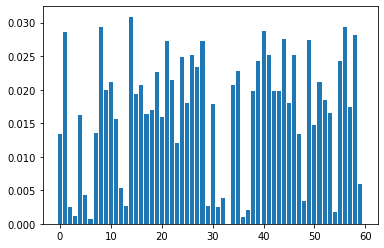

In [191]:

lengths = cdist([centroid_history[0, 0]], data)[0]
lengths /= lengths.sum()
plt.bar(np.arange(lengths.shape[0]), lengths)

0.980681939468089


<BarContainer object of 1 artists>

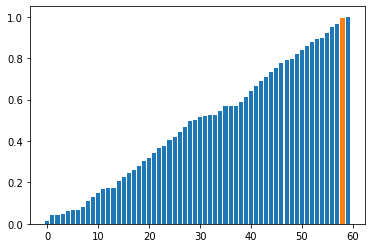

In [237]:
selection = lengths.cumsum()
selection /= selection[-1]
plt.bar(np.arange(selection.shape[0]), selection)
sample = np.random.random_sample()
print(sample)
idx = selection.searchsorted(sample, side="right")
plt.bar(idx, selection[idx])

<BarContainer object of 1 artists>

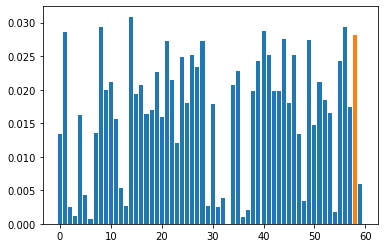

In [238]:
lengths = cdist([centroid_history[0, 0]], data)[0]
lengths /= lengths.sum()
plt.bar(np.arange(lengths.shape[0]), lengths)
plt.bar(idx, lengths[idx])

In [225]:
combined = np.insert(lengths / lengths.max(), np.arange(selection.shape[0]), selection)

<BarContainer object of 120 artists>

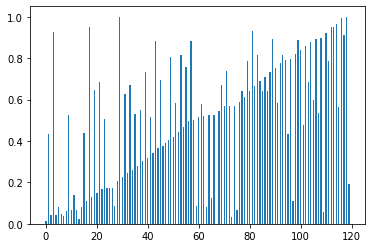

In [230]:
plt.bar(np.arange(combined.shape[0]), combined, width=0.5)

In [10]:
import numpy as np

history = np.load("data/centroid_history2.npy")
history.shape

# history = np.pad(history, ((0, 1), (0, 0)))
history[0, 1]

array([4.00194113, 1.70542621])

<BarContainer object of 8 artists>

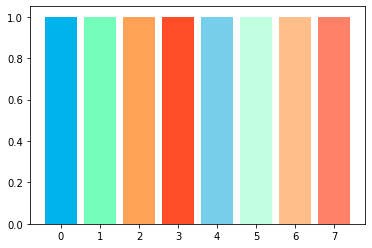

In [13]:
# Dot colors
C1_COLOR = "#00b4eb"
C2_COLOR = "#74feba"
C3_COLOR = "#ffa256"
C4_COLOR = "#ff4d27"

D1_COLOR = "#75cfeb"
D2_COLOR = "#bfffdf"
D3_COLOR = "#ffbe8a"
D4_COLOR = "#ff8266"
colors = [C1_COLOR, C2_COLOR, C3_COLOR, C4_COLOR, D1_COLOR, D2_COLOR, D3_COLOR, D4_COLOR]

plt.bar(np.arange(8), 1, color=colors)

In [18]:
history = np.load("data/centroid_history2.npy")
history = np.equal(history[:1], history[1:])
history

array([[4, 4],
       [4, 4],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0,